## Import Library

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


## Assess Dataset

In [4]:
print(os.listdir())

['.DS_Store', 'dogcat.ipynb', 'model.dogcat', 'sampleSubmission.csv', 'test1', 'submission.csv', 'test1.zip', 'train', '.ipynb_checkpoints', 'train.zip']


In [5]:
filenames = os.listdir('train')   

## Classify Images

Prepare the training dataset, and split dog and cat images into two groups.

In [19]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


See how the number of images in each group

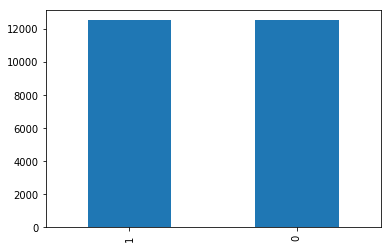

In [20]:
df['category'].value_counts().plot.bar()

A sample picture

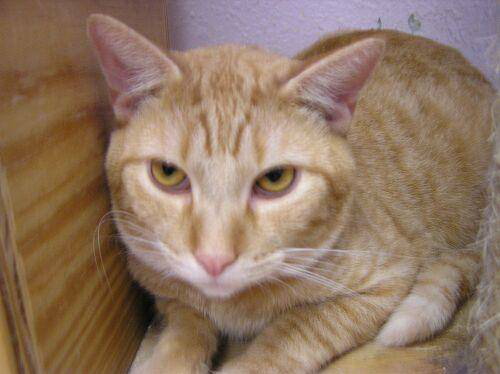

In [23]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
image

Import the required Keras library for CNN

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras import backend as K
from keras.regularizers import l2
from keras.optimizers import Adam

## Set up the CNN Model

In [25]:
height = 128
width = 128
depth = 3

init="he_normal"
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    

# our first convolutional neural layer will learn a total of 16 filters, each
# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
# the spatial dimensions of the volume
        
model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))

# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))


# stack two more CONV layers, keeping the size of each filter
# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))


# increase the number of filters again, this time to 128
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))


model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init,
                 kernel_regularizer=l2(0.0005), input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))


# fully-connected layer.
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.5))

# sigmoid classifier (softmax is for multi-classes)
model.add(Dense(1, activation='sigmoid'))


model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 61, 61, 16)        2368      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
activation_29 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 31, 31, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 31, 31, 32)        128       
__________

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [15]:
earlystop = EarlyStopping(patience=10)

## Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare Test and Train Data¶


In [26]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

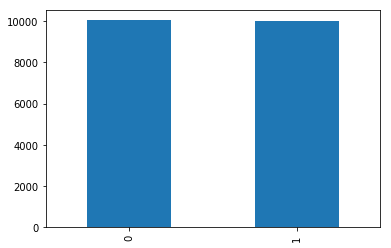

In [27]:
train_df['category'].value_counts().plot.bar()

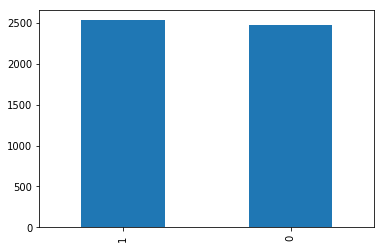

In [28]:
validate_df['category'].value_counts().plot.bar()

In [30]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [31]:
train_df['category'] = train_df['category'].astype(str)
validate_df['category'] = validate_df['category'].astype(str)

In [32]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=15, 
                         zoom_range=0.2,
                         rescale=1./255,
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.1,
                         horizontal_flip=True, 
                         fill_mode="reflect")

train_generator = aug.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


A exmaple of output

In [34]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = aug.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=(128,128),   
)



Found 1 images belonging to 1 classes.


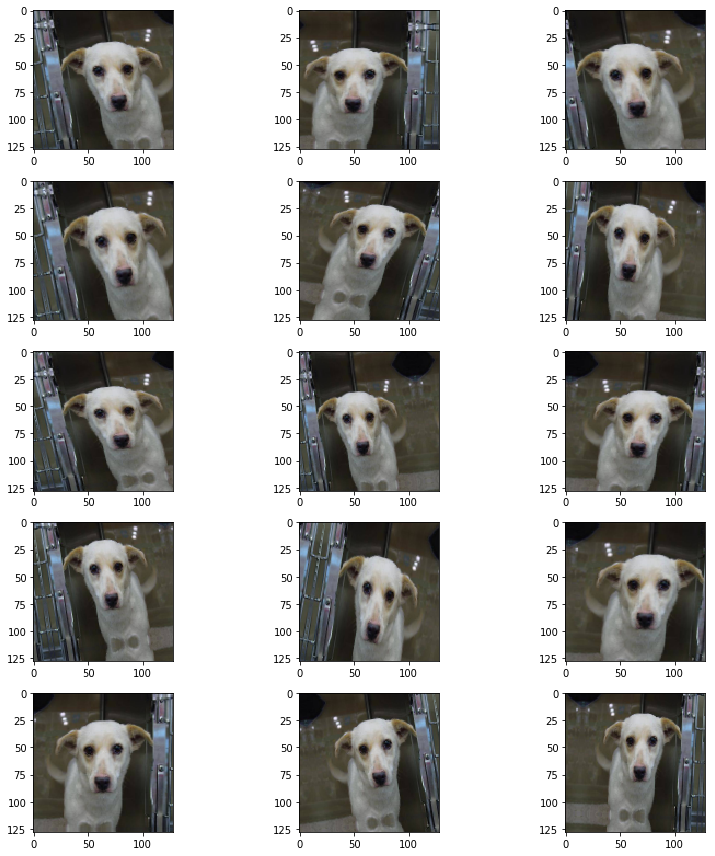

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [36]:
FAST_RUN = False

In [38]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
625/625 [==============================] - 814s 1s/step - loss: 0.6337 - acc: 0.7944 - val_loss: 0.5852 - val_acc: 0.8078
Epoch 2/50
625/625 [==============================] - 540s 864ms/step - loss: 0.5823 - acc: 0.8106 - val_loss: 0.5296 - val_acc: 0.8404
Epoch 3/50
625/625 [==============================] - 561s 897ms/step - loss: 0.5510 - acc: 0.8180 - val_loss: 0.7259 - val_acc: 0.7478
Epoch 4/50
625/625 [==============================] - 579s 926ms/step - loss: 0.5059 - acc: 0.8388 - val_loss: 0.8178 - val_acc: 0.7218

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/50
625/625 [==============================] - 584s 935ms/step - loss: 0.4579 - acc: 0.8584 - val_loss: 0.3953 - val_acc: 0.8873
Epoch 6/50
625/625 [==============================] - 589s 942ms/step - loss: 0.4377 - acc: 0.8641 - val_loss: 0.4042 - val_acc: 0.8784
Epoch 7/50
625/625 [==============================] - 581s 930ms/step - loss: 0.4208 - acc: 0.8719 - val_l

## Save the model

In [39]:
model.save_weights("model.dogcat")

## Virtualize Training

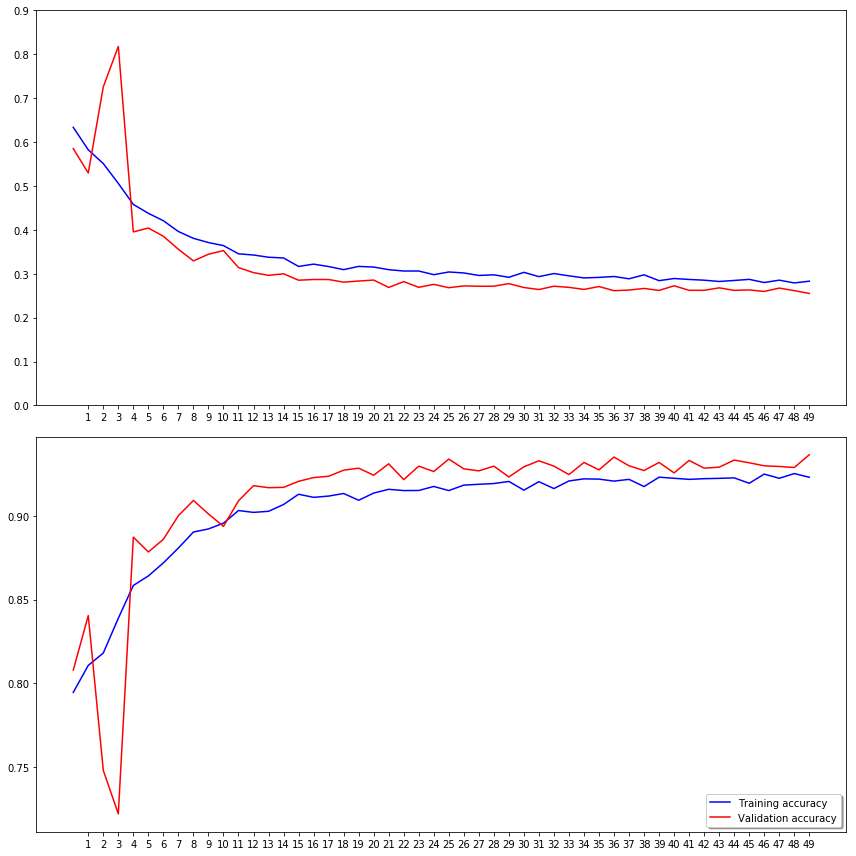

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='lower right', shadow=True)
plt.tight_layout()
plt.show()

## Testing Data

In [45]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [49]:
# construct the testing image generator for data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col='None',
    class_mode=None,
    target_size=(128, 128),
    shuffle = False,
    batch_size=batch_size
)

Found 12500 images.


## Prediction

In [50]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [91]:
threshold = 0.4
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

## Visualize the result

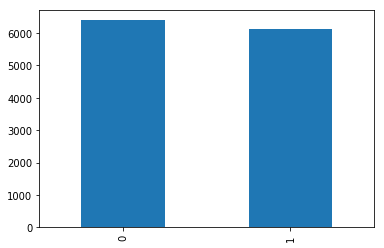

In [92]:
test_df['category'].value_counts().plot.bar()

See predicted results with the first 24 images 

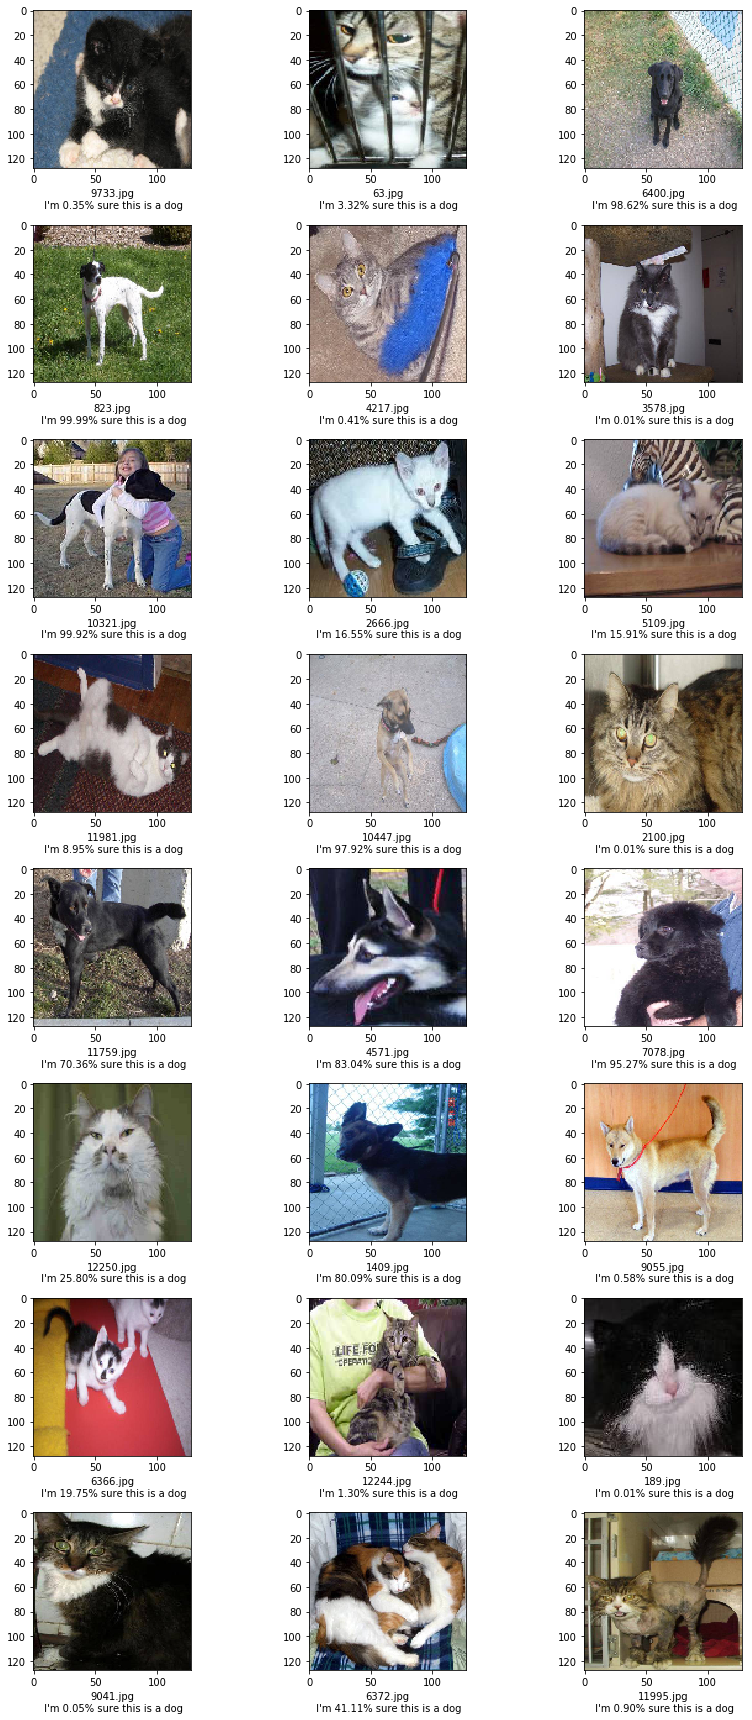

In [93]:
sample_test = test_df.head(24)
sample_test.head()
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("test1/"+filename, target_size=(128,128))
    
    plt.subplot(8, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename  + "\n I'm {:.2%} sure this is a dog".format(probability))

plt.tight_layout()
plt.show()

## Submission

In [84]:
submission = test_df.copy()
submission['id'] = submission['filename'].str.split('.').str[0]
submission['label'] = submission['category']
submission.drop(['filename', 'category'], axis=1, inplace=True)
submission.to_csv('submission.csv', index=False)